In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


(15060, 41)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_______________________________________

30162/30162 [==============================] - 2s 59us/step - loss: 0.3686 - accuracy: 0.8329 - val_loss: 0.3406 - val_accuracy: 0.8447
Epoch 42/100
30162/30162 [==============================] - 2s 58us/step - loss: 0.3685 - accuracy: 0.8316 - val_loss: 0.3405 - val_accuracy: 0.8447
Epoch 43/100
30162/30162 [==============================] - 2s 54us/step - loss: 0.3708 - accuracy: 0.8329 - val_loss: 0.3405 - val_accuracy: 0.8446
Epoch 44/100
30162/30162 [==============================] - 1s 49us/step - loss: 0.3726 - accuracy: 0.8296 - val_loss: 0.3404 - val_accuracy: 0.8446
Epoch 45/100
30162/30162 [==============================] - 2s 56us/step - loss: 0.3708 - accuracy: 0.8315 - val_loss: 0.3403 - val_accuracy: 0.8446
Epoch 46/100
30162/30162 [==============================] - 2s 54us/step - loss: 0.3694 - accuracy: 0.8306 - val_loss: 0.3403 - val_accuracy: 0.8446
Epoch 47/100
30162/30162 [==============================] - 2s 52us/step - loss: 0.3675 - accuracy: 0.8309 - val_loss: 

30162/30162 [==============================] - 1s 48us/step - loss: 0.3680 - accuracy: 0.8328 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 97/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3678 - accuracy: 0.8320 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 98/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3713 - accuracy: 0.8297 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 99/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3665 - accuracy: 0.8330 - val_loss: 0.3393 - val_accuracy: 0.8452
Epoch 100/100
30162/30162 [==============================] - 1s 48us/step - loss: 0.3660 - accuracy: 0.8332 - val_loss: 0.3393 - val_accuracy: 0.8452


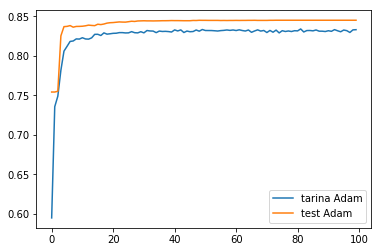

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do do modelu 
```python
model.add(Dropout(0.8))
```
po każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

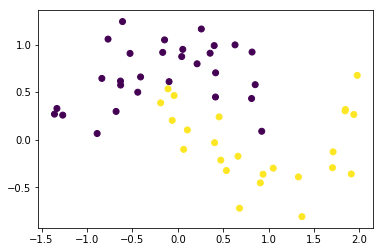

In [10]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [11]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5660 - val_loss: 0.6948 - val_accuracy: 0.5532
Epoch 2/1000
53/53 [==============================] - 0s 527

53/53 [==============================] - 0s 527us/step - loss: 0.1870 - accuracy: 0.9245 - val_loss: 0.4663 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 546us/step - loss: 0.1836 - accuracy: 0.9057 - val_loss: 0.4857 - val_accuracy: 0.8085
Epoch 53/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1863 - accuracy: 0.9434 - val_loss: 0.4960 - val_accuracy: 0.8085
Epoch 54/1000
53/53 [==============================] - 0s 546us/step - loss: 0.1868 - accuracy: 0.9434 - val_loss: 0.4807 - val_accuracy: 0.8298
Epoch 55/1000
53/53 [==============================] - 0s 564us/step - loss: 0.1812 - accuracy: 0.9245 - val_loss: 0.4728 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 602us/step - loss: 0.1803 - accuracy: 0.9245 - val_loss: 0.4586 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1806 - accuracy: 0.9245 - val_loss: 0.4363 - val_accuracy: 0.8298

53/53 [==============================] - 0s 546us/step - loss: 0.0687 - accuracy: 0.9811 - val_loss: 0.2293 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0675 - accuracy: 0.9811 - val_loss: 0.2144 - val_accuracy: 0.8936
Epoch 109/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0666 - accuracy: 0.9811 - val_loss: 0.2113 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 584us/step - loss: 0.0643 - accuracy: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0612 - accuracy: 1.0000 - val_loss: 0.2197 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0608 - accuracy: 0.9811 - val_loss: 0.2229 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0568 - accuracy: 0.9811 - val_loss: 0.2323 - val_accuracy: 

53/53 [==============================] - 0s 565us/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1734 - val_accuracy: 0.9149
Epoch 164/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9149
Epoch 165/1000
53/53 [==============================] - 0s 470us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.1795 - val_accuracy: 0.9149
Epoch 166/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9149
Epoch 167/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.1817 - val_accuracy: 0.9149
Epoch 168/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1832 - val_accuracy: 0.9149
Epoch 169/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.1868 - val_accuracy: 

53/53 [==============================] - 0s 546us/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1907 - val_accuracy: 0.9149
Epoch 220/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.8936
Epoch 221/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.8936
Epoch 222/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1965 - val_accuracy: 0.8936
Epoch 223/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.8936
Epoch 224/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.2025 - val_accuracy: 0.9149
Epoch 225/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2022 - val_accuracy: 

53/53 [==============================] - 0s 527us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2105 - val_accuracy: 0.9149
Epoch 276/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9149
Epoch 277/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2116 - val_accuracy: 0.9149
Epoch 278/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2130 - val_accuracy: 0.9149
Epoch 279/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2137 - val_accuracy: 0.9149
Epoch 280/1000
53/53 [==============================] - 0s 564us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2138 - val_accuracy: 0.9149
Epoch 281/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2140 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2262 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2257 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2261 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2264 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2277 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9149
Epoch 388/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.9149
Epoch 389/1000
53/53 [==============================] - 0s 771us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2410 - val_accuracy: 0.9149
Epoch 390/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9149
Epoch 391/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2409 - val_accuracy: 0.9149
Epoch 392/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9149
Epoch 393/1000
53/53 [==============================] - 0s 678us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2420 - val_accuracy: 

53/53 [==============================] - 0s 809us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2592 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2590 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2602 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2620 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2631 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 678us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2650 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2644 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 696us/step - loss: 9.9375e-04 - accuracy: 1.0000 - val_loss: 0.2780 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2781 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 696us/step - loss: 9.7589e-04 - accuracy: 1.0000 - val_loss: 0.2768 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 753us/step - loss: 9.6190e-04 - accuracy: 1.0000 - val_loss: 0.2756 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 734us/step - loss: 9.7463e-04 - accuracy: 1.0000 - val_loss: 0.2754 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2754 

Epoch 554/1000
53/53 [==============================] - 0s 640us/step - loss: 7.6201e-04 - accuracy: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.9149
Epoch 555/1000
53/53 [==============================] - 0s 753us/step - loss: 7.7629e-04 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 706us/step - loss: 7.6856e-04 - accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 640us/step - loss: 7.5178e-04 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 583us/step - loss: 7.4824e-04 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 715us/step - loss: 7.3772e-04 - accuracy: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.9149
Epoch 560/1000
53/53 [==============================] - 0s 696us/step - loss: 7.2462e-04 - accuracy:

53/53 [==============================] - 0s 659us/step - loss: 5.8151e-04 - accuracy: 1.0000 - val_loss: 0.3087 - val_accuracy: 0.9149
Epoch 609/1000
53/53 [==============================] - 0s 753us/step - loss: 5.7027e-04 - accuracy: 1.0000 - val_loss: 0.3109 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 640us/step - loss: 5.9616e-04 - accuracy: 1.0000 - val_loss: 0.3131 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 809us/step - loss: 6.2676e-04 - accuracy: 1.0000 - val_loss: 0.3140 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 772us/step - loss: 5.9902e-04 - accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 809us/step - loss: 5.6192e-04 - accuracy: 1.0000 - val_loss: 0.3102 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 809us/step - loss: 5.6757e-04 - accuracy: 1.0000 - val_l

Epoch 663/1000
53/53 [==============================] - 0s 696us/step - loss: 4.6076e-04 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9149
Epoch 664/1000
53/53 [==============================] - 0s 734us/step - loss: 4.6664e-04 - accuracy: 1.0000 - val_loss: 0.3240 - val_accuracy: 0.9149
Epoch 665/1000
53/53 [==============================] - 0s 772us/step - loss: 4.5771e-04 - accuracy: 1.0000 - val_loss: 0.3250 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 809us/step - loss: 4.5769e-04 - accuracy: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 828us/step - loss: 4.6393e-04 - accuracy: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 772us/step - loss: 4.7079e-04 - accuracy: 1.0000 - val_loss: 0.3263 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 715us/step - loss: 4.5875e-04 - accuracy:

53/53 [==============================] - 0s 677us/step - loss: 3.7986e-04 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9149
Epoch 718/1000
53/53 [==============================] - 0s 715us/step - loss: 3.7666e-04 - accuracy: 1.0000 - val_loss: 0.3373 - val_accuracy: 0.9149
Epoch 719/1000
53/53 [==============================] - 0s 602us/step - loss: 3.7593e-04 - accuracy: 1.0000 - val_loss: 0.3364 - val_accuracy: 0.9149
Epoch 720/1000
53/53 [==============================] - 0s 715us/step - loss: 3.8247e-04 - accuracy: 1.0000 - val_loss: 0.3359 - val_accuracy: 0.9149
Epoch 721/1000
53/53 [==============================] - 0s 734us/step - loss: 3.8171e-04 - accuracy: 1.0000 - val_loss: 0.3364 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 771us/step - loss: 3.7719e-04 - accuracy: 1.0000 - val_loss: 0.3373 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 753us/step - loss: 3.7215e-04 - accuracy: 1.0000 - val_l

Epoch 772/1000
53/53 [==============================] - 0s 640us/step - loss: 3.1598e-04 - accuracy: 1.0000 - val_loss: 0.3484 - val_accuracy: 0.9149
Epoch 773/1000
53/53 [==============================] - 0s 809us/step - loss: 3.1225e-04 - accuracy: 1.0000 - val_loss: 0.3493 - val_accuracy: 0.9149
Epoch 774/1000
53/53 [==============================] - 0s 791us/step - loss: 3.0914e-04 - accuracy: 1.0000 - val_loss: 0.3501 - val_accuracy: 0.9149
Epoch 775/1000
53/53 [==============================] - 0s 886us/step - loss: 3.0774e-04 - accuracy: 1.0000 - val_loss: 0.3508 - val_accuracy: 0.9149
Epoch 776/1000
53/53 [==============================] - 0s 809us/step - loss: 3.0713e-04 - accuracy: 1.0000 - val_loss: 0.3514 - val_accuracy: 0.9149
Epoch 777/1000
53/53 [==============================] - 0s 790us/step - loss: 3.0693e-04 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.9149
Epoch 778/1000
53/53 [==============================] - 0s 866us/step - loss: 3.1279e-04 - accuracy:

53/53 [==============================] - 0s 659us/step - loss: 2.6177e-04 - accuracy: 1.0000 - val_loss: 0.3632 - val_accuracy: 0.9149
Epoch 827/1000
53/53 [==============================] - 0s 640us/step - loss: 2.6544e-04 - accuracy: 1.0000 - val_loss: 0.3636 - val_accuracy: 0.9149
Epoch 828/1000
53/53 [==============================] - 0s 753us/step - loss: 2.6736e-04 - accuracy: 1.0000 - val_loss: 0.3633 - val_accuracy: 0.9149
Epoch 829/1000
53/53 [==============================] - 0s 696us/step - loss: 2.6344e-04 - accuracy: 1.0000 - val_loss: 0.3636 - val_accuracy: 0.9149
Epoch 830/1000
53/53 [==============================] - 0s 677us/step - loss: 2.5822e-04 - accuracy: 1.0000 - val_loss: 0.3635 - val_accuracy: 0.9149
Epoch 831/1000
53/53 [==============================] - 0s 659us/step - loss: 2.6476e-04 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.9149
Epoch 832/1000
53/53 [==============================] - 0s 659us/step - loss: 2.5700e-04 - accuracy: 1.0000 - val_l

53/53 [==============================] - 0s 677us/step - loss: 2.2588e-04 - accuracy: 1.0000 - val_loss: 0.3721 - val_accuracy: 0.8936
Epoch 881/1000
53/53 [==============================] - 0s 640us/step - loss: 2.2224e-04 - accuracy: 1.0000 - val_loss: 0.3732 - val_accuracy: 0.8936
Epoch 882/1000
53/53 [==============================] - 0s 602us/step - loss: 2.2071e-04 - accuracy: 1.0000 - val_loss: 0.3749 - val_accuracy: 0.8936
Epoch 883/1000
53/53 [==============================] - 0s 659us/step - loss: 2.2092e-04 - accuracy: 1.0000 - val_loss: 0.3760 - val_accuracy: 0.8936
Epoch 884/1000
53/53 [==============================] - 0s 659us/step - loss: 2.2841e-04 - accuracy: 1.0000 - val_loss: 0.3769 - val_accuracy: 0.8936
Epoch 885/1000
53/53 [==============================] - 0s 715us/step - loss: 2.2286e-04 - accuracy: 1.0000 - val_loss: 0.3766 - val_accuracy: 0.8936
Epoch 886/1000
53/53 [==============================] - 0s 659us/step - loss: 2.2020e-04 - accuracy: 1.0000 - val_l

Epoch 935/1000
53/53 [==============================] - 0s 659us/step - loss: 1.9228e-04 - accuracy: 1.0000 - val_loss: 0.3830 - val_accuracy: 0.8936
Epoch 936/1000
53/53 [==============================] - 0s 659us/step - loss: 1.9054e-04 - accuracy: 1.0000 - val_loss: 0.3837 - val_accuracy: 0.8936
Epoch 937/1000
53/53 [==============================] - 0s 753us/step - loss: 1.8906e-04 - accuracy: 1.0000 - val_loss: 0.3844 - val_accuracy: 0.8936
Epoch 938/1000
53/53 [==============================] - 0s 696us/step - loss: 1.8828e-04 - accuracy: 1.0000 - val_loss: 0.3851 - val_accuracy: 0.8936
Epoch 939/1000
53/53 [==============================] - 0s 696us/step - loss: 1.8781e-04 - accuracy: 1.0000 - val_loss: 0.3856 - val_accuracy: 0.8936
Epoch 940/1000
53/53 [==============================] - 0s 602us/step - loss: 1.9131e-04 - accuracy: 1.0000 - val_loss: 0.3861 - val_accuracy: 0.8936
Epoch 941/1000
53/53 [==============================] - 0s 659us/step - loss: 1.8705e-04 - accuracy:

53/53 [==============================] - 0s 621us/step - loss: 1.6406e-04 - accuracy: 1.0000 - val_loss: 0.3919 - val_accuracy: 0.8936
Epoch 990/1000
53/53 [==============================] - 0s 734us/step - loss: 1.6371e-04 - accuracy: 1.0000 - val_loss: 0.3914 - val_accuracy: 0.8936
Epoch 991/1000
53/53 [==============================] - 0s 828us/step - loss: 1.7046e-04 - accuracy: 1.0000 - val_loss: 0.3908 - val_accuracy: 0.8936
Epoch 992/1000
53/53 [==============================] - 0s 715us/step - loss: 1.6861e-04 - accuracy: 1.0000 - val_loss: 0.3912 - val_accuracy: 0.8936
Epoch 993/1000
53/53 [==============================] - 0s 772us/step - loss: 1.6533e-04 - accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 0.8936
Epoch 994/1000
53/53 [==============================] - 0s 734us/step - loss: 1.6245e-04 - accuracy: 1.0000 - val_loss: 0.3935 - val_accuracy: 0.8936
Epoch 995/1000
53/53 [==============================] - 0s 790us/step - loss: 1.6070e-04 - accuracy: 1.0000 - val_l

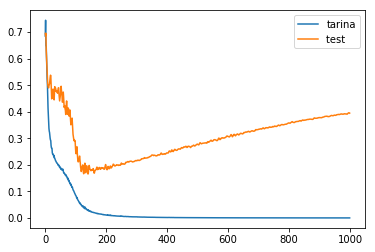

In [17]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


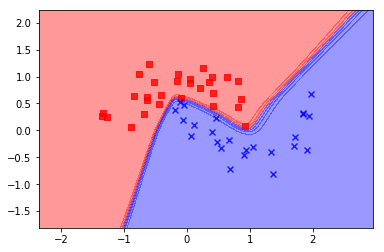

In [18]:
from help_plot import plot_decision_regions
plot_decision_regions(X_train, y_train, model)
plt.show()

In [14]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.8))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

53/53 [==============================] - 0s 621us/step - loss: 0.4738 - accuracy: 0.7170 - val_loss: 0.4704 - val_accuracy: 0.7660
Epoch 46/1000
53/53 [==============================] - 0s 621us/step - loss: 0.4184 - accuracy: 0.8679 - val_loss: 0.4706 - val_accuracy: 0.7660
Epoch 47/1000
53/53 [==============================] - 0s 565us/step - loss: 0.5552 - accuracy: 0.7170 - val_loss: 0.4706 - val_accuracy: 0.7660
Epoch 48/1000
53/53 [==============================] - 0s 565us/step - loss: 0.4275 - accuracy: 0.7358 - val_loss: 0.4723 - val_accuracy: 0.7660
Epoch 49/1000
53/53 [==============================] - 0s 602us/step - loss: 0.5171 - accuracy: 0.7547 - val_loss: 0.4704 - val_accuracy: 0.7660
Epoch 50/1000
53/53 [==============================] - 0s 602us/step - loss: 0.4649 - accuracy: 0.7358 - val_loss: 0.4695 - val_accuracy: 0.7447
Epoch 51/1000
53/53 [==============================] - 0s 621us/step - loss: 0.5591 - accuracy: 0.7547 - val_loss: 0.4702 - val_accuracy: 0.7447

53/53 [==============================] - 0s 602us/step - loss: 0.3068 - accuracy: 0.8679 - val_loss: 0.5224 - val_accuracy: 0.7872
Epoch 102/1000
53/53 [==============================] - 0s 602us/step - loss: 0.3077 - accuracy: 0.9057 - val_loss: 0.5182 - val_accuracy: 0.7872
Epoch 103/1000
53/53 [==============================] - 0s 621us/step - loss: 0.3517 - accuracy: 0.8491 - val_loss: 0.5133 - val_accuracy: 0.7872
Epoch 104/1000
53/53 [==============================] - 0s 583us/step - loss: 0.3029 - accuracy: 0.8868 - val_loss: 0.5108 - val_accuracy: 0.7872
Epoch 105/1000
53/53 [==============================] - 0s 583us/step - loss: 0.3077 - accuracy: 0.9057 - val_loss: 0.5107 - val_accuracy: 0.7872
Epoch 106/1000
53/53 [==============================] - 0s 584us/step - loss: 0.2960 - accuracy: 0.9057 - val_loss: 0.5107 - val_accuracy: 0.7872
Epoch 107/1000
53/53 [==============================] - 0s 602us/step - loss: 0.2670 - accuracy: 0.8491 - val_loss: 0.5139 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.2139 - accuracy: 0.9245 - val_loss: 0.5333 - val_accuracy: 0.8085
Epoch 158/1000
53/53 [==============================] - 0s 640us/step - loss: 0.3193 - accuracy: 0.8868 - val_loss: 0.5370 - val_accuracy: 0.8298
Epoch 159/1000
53/53 [==============================] - 0s 583us/step - loss: 0.3026 - accuracy: 0.9245 - val_loss: 0.5378 - val_accuracy: 0.8298
Epoch 160/1000
53/53 [==============================] - 0s 583us/step - loss: 0.2359 - accuracy: 0.8868 - val_loss: 0.5341 - val_accuracy: 0.8298
Epoch 161/1000
53/53 [==============================] - 0s 602us/step - loss: 0.2726 - accuracy: 0.8868 - val_loss: 0.5282 - val_accuracy: 0.8298
Epoch 162/1000
53/53 [==============================] - 0s 602us/step - loss: 0.2773 - accuracy: 0.8679 - val_loss: 0.5237 - val_accuracy: 0.8085
Epoch 163/1000
53/53 [==============================] - 0s 564us/step - loss: 0.2574 - accuracy: 0.8868 - val_loss: 0.5204 - val_accuracy: 

53/53 [==============================] - 0s 734us/step - loss: 0.2389 - accuracy: 0.9057 - val_loss: 0.4646 - val_accuracy: 0.8085
Epoch 214/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2522 - accuracy: 0.8868 - val_loss: 0.4638 - val_accuracy: 0.8085
Epoch 215/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2523 - accuracy: 0.8679 - val_loss: 0.4642 - val_accuracy: 0.8085
Epoch 216/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1871 - accuracy: 0.9057 - val_loss: 0.4634 - val_accuracy: 0.8085
Epoch 217/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2613 - accuracy: 0.8679 - val_loss: 0.4641 - val_accuracy: 0.8085
Epoch 218/1000
53/53 [==============================] - 0s 847us/step - loss: 0.1947 - accuracy: 0.9245 - val_loss: 0.4657 - val_accuracy: 0.8085
Epoch 219/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2068 - accuracy: 0.9245 - val_loss: 0.4680 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.1930 - accuracy: 0.9057 - val_loss: 0.4559 - val_accuracy: 0.8085
Epoch 270/1000
53/53 [==============================] - 0s 602us/step - loss: 0.3012 - accuracy: 0.8679 - val_loss: 0.4563 - val_accuracy: 0.8085
Epoch 271/1000
53/53 [==============================] - 0s 602us/step - loss: 0.2457 - accuracy: 0.9057 - val_loss: 0.4583 - val_accuracy: 0.8085
Epoch 272/1000
53/53 [==============================] - 0s 583us/step - loss: 0.2323 - accuracy: 0.8679 - val_loss: 0.4621 - val_accuracy: 0.8085
Epoch 273/1000
53/53 [==============================] - 0s 583us/step - loss: 0.2373 - accuracy: 0.9057 - val_loss: 0.4662 - val_accuracy: 0.8085
Epoch 274/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2842 - accuracy: 0.8868 - val_loss: 0.4690 - val_accuracy: 0.8298
Epoch 275/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2561 - accuracy: 0.9057 - val_loss: 0.4692 - val_accuracy: 

53/53 [==============================] - 0s 884us/step - loss: 0.2232 - accuracy: 0.9434 - val_loss: 0.4375 - val_accuracy: 0.8085
Epoch 326/1000
53/53 [==============================] - 0s 809us/step - loss: 0.2334 - accuracy: 0.8868 - val_loss: 0.4365 - val_accuracy: 0.8085
Epoch 327/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2126 - accuracy: 0.9623 - val_loss: 0.4360 - val_accuracy: 0.8085
Epoch 328/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.2616 - accuracy: 0.8679 - val_loss: 0.4363 - val_accuracy: 0.8085
Epoch 329/1000
53/53 [==============================] - 0s 922us/step - loss: 0.2439 - accuracy: 0.8868 - val_loss: 0.4355 - val_accuracy: 0.8085
Epoch 330/1000
53/53 [==============================] - 0s 922us/step - loss: 0.2102 - accuracy: 0.9434 - val_loss: 0.4383 - val_accuracy: 0.8085
Epoch 331/1000
53/53 [==============================] - 0s 997us/step - loss: 0.1842 - accuracy: 0.9434 - val_loss: 0.4390 - val_accuracy: 0.

53/53 [==============================] - 0s 677us/step - loss: 0.1753 - accuracy: 0.9434 - val_loss: 0.4336 - val_accuracy: 0.8085
Epoch 382/1000
53/53 [==============================] - 0s 704us/step - loss: 0.1635 - accuracy: 0.9623 - val_loss: 0.4313 - val_accuracy: 0.8085
Epoch 383/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2265 - accuracy: 0.9057 - val_loss: 0.4309 - val_accuracy: 0.8085
Epoch 384/1000
53/53 [==============================] - 0s 790us/step - loss: 0.1830 - accuracy: 0.9245 - val_loss: 0.4308 - val_accuracy: 0.8085
Epoch 385/1000
53/53 [==============================] - 0s 608us/step - loss: 0.1684 - accuracy: 0.9245 - val_loss: 0.4306 - val_accuracy: 0.8085
Epoch 386/1000
53/53 [==============================] - 0s 602us/step - loss: 0.1969 - accuracy: 0.9434 - val_loss: 0.4315 - val_accuracy: 0.8085
Epoch 387/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1919 - accuracy: 0.9245 - val_loss: 0.4326 - val_accuracy: 

53/53 [==============================] - 0s 583us/step - loss: 0.1607 - accuracy: 0.9434 - val_loss: 0.4041 - val_accuracy: 0.8511
Epoch 438/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1647 - accuracy: 0.9245 - val_loss: 0.4036 - val_accuracy: 0.8511
Epoch 439/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2062 - accuracy: 0.9434 - val_loss: 0.4035 - val_accuracy: 0.8511
Epoch 440/1000
53/53 [==============================] - 0s 640us/step - loss: 0.1552 - accuracy: 0.9811 - val_loss: 0.4028 - val_accuracy: 0.8511
Epoch 441/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2144 - accuracy: 0.9057 - val_loss: 0.4020 - val_accuracy: 0.8511
Epoch 442/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2646 - accuracy: 0.9057 - val_loss: 0.4019 - val_accuracy: 0.8511
Epoch 443/1000
53/53 [==============================] - 0s 621us/step - loss: 0.1579 - accuracy: 0.9434 - val_loss: 0.4019 - val_accuracy: 

53/53 [==============================] - 0s 583us/step - loss: 0.1344 - accuracy: 0.9623 - val_loss: 0.4155 - val_accuracy: 0.8511
Epoch 494/1000
53/53 [==============================] - 0s 602us/step - loss: 0.1589 - accuracy: 0.9434 - val_loss: 0.4155 - val_accuracy: 0.8511
Epoch 495/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2068 - accuracy: 0.9057 - val_loss: 0.4136 - val_accuracy: 0.8511
Epoch 496/1000
53/53 [==============================] - 0s 583us/step - loss: 0.1644 - accuracy: 0.9057 - val_loss: 0.4129 - val_accuracy: 0.8511
Epoch 497/1000
53/53 [==============================] - 0s 602us/step - loss: 0.1446 - accuracy: 0.9245 - val_loss: 0.4101 - val_accuracy: 0.8511
Epoch 498/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1510 - accuracy: 0.9434 - val_loss: 0.4081 - val_accuracy: 0.8511
Epoch 499/1000
53/53 [==============================] - 0s 621us/step - loss: 0.1314 - accuracy: 0.9623 - val_loss: 0.4065 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.1360 - accuracy: 0.9623 - val_loss: 0.3801 - val_accuracy: 0.8511
Epoch 550/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1682 - accuracy: 0.9434 - val_loss: 0.3785 - val_accuracy: 0.8511
Epoch 551/1000
53/53 [==============================] - 0s 753us/step - loss: 0.1562 - accuracy: 0.9623 - val_loss: 0.3773 - val_accuracy: 0.8511
Epoch 552/1000
53/53 [==============================] - 0s 656us/step - loss: 0.1027 - accuracy: 0.9434 - val_loss: 0.3745 - val_accuracy: 0.8511
Epoch 553/1000
53/53 [==============================] - 0s 621us/step - loss: 0.1347 - accuracy: 0.9434 - val_loss: 0.3700 - val_accuracy: 0.8723
Epoch 554/1000
53/53 [==============================] - 0s 621us/step - loss: 0.1601 - accuracy: 0.9623 - val_loss: 0.3658 - val_accuracy: 0.8723
Epoch 555/1000
53/53 [==============================] - 0s 809us/step - loss: 0.1203 - accuracy: 0.9623 - val_loss: 0.3620 - val_accuracy: 

53/53 [==============================] - 0s 678us/step - loss: 0.1331 - accuracy: 0.9434 - val_loss: 0.3210 - val_accuracy: 0.8723
Epoch 606/1000
53/53 [==============================] - 0s 621us/step - loss: 0.1396 - accuracy: 0.9434 - val_loss: 0.3239 - val_accuracy: 0.8723
Epoch 607/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1282 - accuracy: 0.9811 - val_loss: 0.3253 - val_accuracy: 0.8723
Epoch 608/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1285 - accuracy: 0.9623 - val_loss: 0.3260 - val_accuracy: 0.8723
Epoch 609/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0934 - accuracy: 0.9623 - val_loss: 0.3268 - val_accuracy: 0.8723
Epoch 610/1000
53/53 [==============================] - 0s 640us/step - loss: 0.1264 - accuracy: 0.9434 - val_loss: 0.3274 - val_accuracy: 0.8723
Epoch 611/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0829 - accuracy: 0.9811 - val_loss: 0.3278 - val_accuracy: 

53/53 [==============================] - 0s 763us/step - loss: 0.1425 - accuracy: 0.9623 - val_loss: 0.2944 - val_accuracy: 0.8723
Epoch 662/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1178 - accuracy: 0.9434 - val_loss: 0.2889 - val_accuracy: 0.8723
Epoch 663/1000
53/53 [==============================] - 0s 772us/step - loss: 0.1057 - accuracy: 0.9623 - val_loss: 0.2870 - val_accuracy: 0.8723
Epoch 664/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1185 - accuracy: 0.9434 - val_loss: 0.2881 - val_accuracy: 0.8723
Epoch 665/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1289 - accuracy: 0.9434 - val_loss: 0.2904 - val_accuracy: 0.8723
Epoch 666/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1116 - accuracy: 0.9434 - val_loss: 0.2908 - val_accuracy: 0.8723
Epoch 667/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0997 - accuracy: 0.9434 - val_loss: 0.2909 - val_accuracy: 

53/53 [==============================] - 0s 678us/step - loss: 0.1478 - accuracy: 0.9245 - val_loss: 0.2791 - val_accuracy: 0.8723
Epoch 718/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 0.2797 - val_accuracy: 0.8723
Epoch 719/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1338 - accuracy: 0.9434 - val_loss: 0.2845 - val_accuracy: 0.8723
Epoch 720/1000
53/53 [==============================] - 0s 753us/step - loss: 0.0597 - accuracy: 0.9623 - val_loss: 0.2879 - val_accuracy: 0.8723
Epoch 721/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1298 - accuracy: 0.9057 - val_loss: 0.2909 - val_accuracy: 0.8723
Epoch 722/1000
53/53 [==============================] - 0s 753us/step - loss: 0.1776 - accuracy: 0.9434 - val_loss: 0.2933 - val_accuracy: 0.8936
Epoch 723/1000
53/53 [==============================] - 0s 790us/step - loss: 0.1295 - accuracy: 0.9623 - val_loss: 0.2946 - val_accuracy: 

53/53 [==============================] - 0s 659us/step - loss: 0.0685 - accuracy: 0.9623 - val_loss: 0.2822 - val_accuracy: 0.8936
Epoch 774/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0906 - accuracy: 0.9623 - val_loss: 0.2793 - val_accuracy: 0.8936
Epoch 775/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0671 - accuracy: 0.9623 - val_loss: 0.2729 - val_accuracy: 0.8936
Epoch 776/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0831 - accuracy: 0.9623 - val_loss: 0.2665 - val_accuracy: 0.8936
Epoch 777/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0523 - accuracy: 0.9811 - val_loss: 0.2632 - val_accuracy: 0.8936
Epoch 778/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0706 - accuracy: 0.9623 - val_loss: 0.2603 - val_accuracy: 0.8936
Epoch 779/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0875 - accuracy: 0.9623 - val_loss: 0.2572 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.0922 - accuracy: 0.9434 - val_loss: 0.2923 - val_accuracy: 0.8936
Epoch 830/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.2938 - val_accuracy: 0.8936
Epoch 831/1000
53/53 [==============================] - 0s 772us/step - loss: 0.1241 - accuracy: 0.9623 - val_loss: 0.2921 - val_accuracy: 0.8936
Epoch 832/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0324 - accuracy: 0.9811 - val_loss: 0.2859 - val_accuracy: 0.8936
Epoch 833/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0594 - accuracy: 0.9623 - val_loss: 0.2801 - val_accuracy: 0.8936
Epoch 834/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0784 - accuracy: 0.9623 - val_loss: 0.2748 - val_accuracy: 0.8936
Epoch 835/1000
53/53 [==============================] - 0s 771us/step - loss: 0.0717 - accuracy: 0.9623 - val_loss: 0.2723 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.2238 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 678us/step - loss: 0.0822 - accuracy: 0.9811 - val_loss: 0.2321 - val_accuracy: 0.9149
Epoch 887/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0824 - accuracy: 0.9245 - val_loss: 0.2429 - val_accuracy: 0.9149
Epoch 888/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.2539 - val_accuracy: 0.8936
Epoch 889/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0736 - accuracy: 0.9434 - val_loss: 0.2644 - val_accuracy: 0.8936
Epoch 890/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0702 - accuracy: 0.9623 - val_loss: 0.2727 - val_accuracy: 0.8936
Epoch 891/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0391 - accuracy: 0.9811 - val_loss: 0.2782 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.1161 - accuracy: 0.9623 - val_loss: 0.2532 - val_accuracy: 0.9149
Epoch 942/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0475 - accuracy: 0.9811 - val_loss: 0.2517 - val_accuracy: 0.8936
Epoch 943/1000
53/53 [==============================] - 0s 771us/step - loss: 0.0546 - accuracy: 0.9811 - val_loss: 0.2475 - val_accuracy: 0.8936
Epoch 944/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 0.2445 - val_accuracy: 0.8936
Epoch 945/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.2421 - val_accuracy: 0.8936
Epoch 946/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0839 - accuracy: 0.9623 - val_loss: 0.2387 - val_accuracy: 0.8936
Epoch 947/1000
53/53 [==============================] - 0s 753us/step - loss: 0.0351 - accuracy: 0.9811 - val_loss: 0.2356 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.0820 - accuracy: 0.9623 - val_loss: 0.2640 - val_accuracy: 0.8936
Epoch 998/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0916 - accuracy: 0.9434 - val_loss: 0.2645 - val_accuracy: 0.8936
Epoch 999/1000
53/53 [==============================] - 0s 753us/step - loss: 0.0371 - accuracy: 0.9623 - val_loss: 0.2659 - val_accuracy: 0.9149
Epoch 1000/1000
53/53 [==============================] - 0s 753us/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 0.2661 - val_accuracy: 0.9149


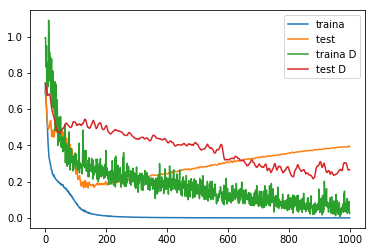

In [22]:
plt.plot(history_Adam.history['loss'], label = "traina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "traina D")
plt.plot(history_Adam_1.history['val_loss'], label = "test D")

plt.legend()
plt.show()

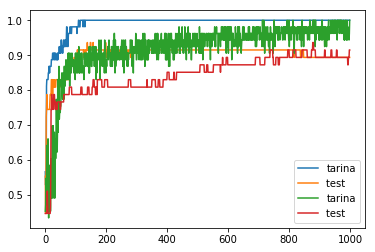

In [20]:
plt.plot(history_Adam.history['accuracy'], label = "tarina")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.plot(history_Adam_1.history['accuracy'], label = "tarina")
plt.plot(history_Adam_1.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


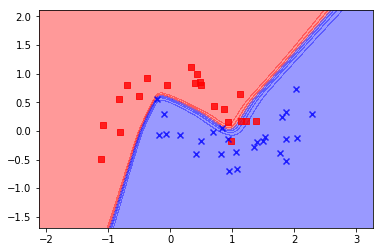

In [16]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do do modelu 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [23]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_15 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.8459 - accuracy: 0.5472 - val_loss: 0.8222 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 565

53/53 [==============================] - 0s 659us/step - loss: 0.2704 - accuracy: 0.9245 - val_loss: 0.5265 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2671 - accuracy: 0.9245 - val_loss: 0.5148 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2643 - accuracy: 0.9245 - val_loss: 0.5014 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2617 - accuracy: 0.9245 - val_loss: 0.4951 - val_accuracy: 0.8298
Epoch 55/1000
53/53 [==============================] - 0s 678us/step - loss: 0.2604 - accuracy: 0.9245 - val_loss: 0.4910 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2574 - accuracy: 0.9245 - val_loss: 0.4948 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2558 - accuracy: 0.9245 - val_loss: 0.5062 - val_accuracy: 0.8298

53/53 [==============================] - 0s 640us/step - loss: 0.1331 - accuracy: 1.0000 - val_loss: 0.2740 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 583us/step - loss: 0.1326 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1316 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 696us/step - loss: 0.1296 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 602us/step - loss: 0.1276 - accuracy: 1.0000 - val_loss: 0.2594 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 922us/step - loss: 0.1273 - accuracy: 1.0000 - val_loss: 0.2582 - val_accuracy: 0.8936
Epoch 113/1000
53/53 [==============================] - 0s 754us/step - loss: 0.1250 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 

53/53 [==============================] - 0s 741us/step - loss: 0.0920 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 0.8936
Epoch 164/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0914 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.8936
Epoch 165/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0910 - accuracy: 1.0000 - val_loss: 0.2409 - val_accuracy: 0.8936
Epoch 166/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0904 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.8936
Epoch 167/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0900 - accuracy: 1.0000 - val_loss: 0.2401 - val_accuracy: 0.8936
Epoch 168/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0900 - accuracy: 1.0000 - val_loss: 0.2418 - val_accuracy: 0.8936
Epoch 169/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0894 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 

53/53 [==============================] - 0s 602us/step - loss: 0.0747 - accuracy: 1.0000 - val_loss: 0.2621 - val_accuracy: 0.8936
Epoch 220/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0749 - accuracy: 1.0000 - val_loss: 0.2647 - val_accuracy: 0.8936
Epoch 221/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0747 - accuracy: 1.0000 - val_loss: 0.2666 - val_accuracy: 0.8936
Epoch 222/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 0.2678 - val_accuracy: 0.8936
Epoch 223/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0745 - accuracy: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.8936
Epoch 224/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 0.2679 - val_accuracy: 0.8936
Epoch 225/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0735 - accuracy: 1.0000 - val_loss: 0.2674 - val_accuracy: 

53/53 [==============================] - 0s 659us/step - loss: 0.0656 - accuracy: 1.0000 - val_loss: 0.2899 - val_accuracy: 0.8936
Epoch 276/1000
53/53 [==============================] - 0s 658us/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.8936
Epoch 277/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.2864 - val_accuracy: 0.8936
Epoch 278/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.2856 - val_accuracy: 0.8936
Epoch 279/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0648 - accuracy: 1.0000 - val_loss: 0.2854 - val_accuracy: 0.8936
Epoch 280/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0646 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.8936
Epoch 281/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0647 - accuracy: 1.0000 - val_loss: 0.2847 - val_accuracy: 

53/53 [==============================] - 0s 583us/step - loss: 0.0585 - accuracy: 1.0000 - val_loss: 0.2969 - val_accuracy: 0.8936
Epoch 332/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 0.2981 - val_accuracy: 0.8936
Epoch 333/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 0.2984 - val_accuracy: 0.8936
Epoch 334/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.2988 - val_accuracy: 0.8936
Epoch 335/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0581 - accuracy: 1.0000 - val_loss: 0.2994 - val_accuracy: 0.8936
Epoch 336/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0585 - accuracy: 1.0000 - val_loss: 0.3011 - val_accuracy: 0.8936
Epoch 337/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0584 - accuracy: 1.0000 - val_loss: 0.3010 - val_accuracy: 

53/53 [==============================] - 0s 602us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 0.3080 - val_accuracy: 0.8936
Epoch 388/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.8936
Epoch 389/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0538 - accuracy: 1.0000 - val_loss: 0.3086 - val_accuracy: 0.8936
Epoch 390/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3094 - val_accuracy: 0.8936
Epoch 391/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.3102 - val_accuracy: 0.8936
Epoch 392/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.8936
Epoch 393/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3104 - val_accuracy: 

53/53 [==============================] - 0s 602us/step - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.3063 - val_accuracy: 0.8936
Epoch 444/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.3050 - val_accuracy: 0.8936
Epoch 445/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.3042 - val_accuracy: 0.8936
Epoch 446/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.3049 - val_accuracy: 0.8936
Epoch 447/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0497 - accuracy: 1.0000 - val_loss: 0.3063 - val_accuracy: 0.8936
Epoch 448/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0495 - accuracy: 1.0000 - val_loss: 0.3078 - val_accuracy: 0.8936
Epoch 449/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0498 - accuracy: 1.0000 - val_loss: 0.3089 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2958 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 0.2925 - val_accuracy: 0.8936
Epoch 502/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2912 - val_accuracy: 0.8936
Epoch 503/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2913 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0466 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0466 - accuracy: 1.0000 - val_loss: 0.2919 - val_accuracy: 

53/53 [==============================] - 0s 603us/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 0.2826 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0440 - accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0439 - accuracy: 1.0000 - val_loss: 0.2849 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0440 - accuracy: 1.0000 - val_loss: 0.2854 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 0.2860 - val_accuracy: 0.9149
Epoch 560/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 0.2861 - val_accuracy: 0.9149
Epoch 561/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.2701 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 0.2687 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.2686 - val_accuracy: 0.9149
Epoch 615/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.9149
Epoch 616/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.9149
Epoch 617/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0411 - accuracy: 1.0000 - val_loss: 0.2699 - val_accuracy: 

Epoch 667/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 508us/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 670/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0389 - accuracy: 1.0000 - val_loss: 0.2590 - val_accuracy: 0.9149
Epoch 671/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.2598 - val_accuracy: 0.9149
Epoch 672/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.2601 - val_accuracy: 0.9149
Epoch 673/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2612 -

53/53 [==============================] - 0s 640us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9149
Epoch 724/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2457 - val_accuracy: 0.9149
Epoch 725/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.2455 - val_accuracy: 0.9149
Epoch 726/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9149
Epoch 727/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.2457 - val_accuracy: 0.9149
Epoch 728/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2457 - val_accuracy: 0.9149
Epoch 729/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 

53/53 [==============================] - 0s 602us/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9149
Epoch 780/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.2385 - val_accuracy: 0.9149
Epoch 781/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.2381 - val_accuracy: 0.9149
Epoch 782/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9149
Epoch 783/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.2386 - val_accuracy: 0.9149
Epoch 784/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 0.9149
Epoch 785/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.2399 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 0.9149
Epoch 836/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9149
Epoch 837/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.2339 - val_accuracy: 0.9149
Epoch 838/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.2327 - val_accuracy: 0.9149
Epoch 839/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 0.9149
Epoch 840/1000
53/53 [==============================] - 0s 658us/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.2301 - val_accuracy: 0.9149
Epoch 841/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.2284 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.2269 - val_accuracy: 0.9149
Epoch 892/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.2277 - val_accuracy: 0.9149
Epoch 893/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.2275 - val_accuracy: 0.9149
Epoch 894/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0307 - accuracy: 1.0000 - val_loss: 0.2274 - val_accuracy: 0.9149
Epoch 895/1000
53/53 [==============================] - 0s 508us/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.2271 - val_accuracy: 0.9149
Epoch 896/1000
53/53 [==============================] - 0s 452us/step - loss: 0.0307 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9149
Epoch 897/1000
53/53 [==============================] - 0s 489us/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 

53/53 [==============================] - 0s 621us/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.2203 - val_accuracy: 0.9362
Epoch 948/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 0.2204 - val_accuracy: 0.9362
Epoch 949/1000
53/53 [==============================] - 0s 621us/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.2206 - val_accuracy: 0.9362
Epoch 950/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.2197 - val_accuracy: 0.9362
Epoch 951/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.2190 - val_accuracy: 0.9362
Epoch 952/1000
53/53 [==============================] - 0s 677us/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 0.2187 - val_accuracy: 0.9362
Epoch 953/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.2184 - val_accuracy: 

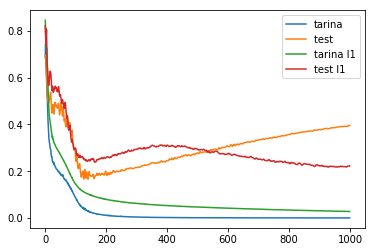

In [27]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


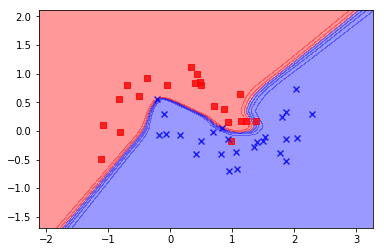

In [25]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()